# Try transfer learning using cGAN discriminator

adapt from here https://github.com/ck44liu/gans-on-image-classification/blob/main/report%20gan%20assignment.pdf

In [1]:
from tensorflow.keras.models import load_model
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv3D, Conv3DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, multiply, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
import numpy as np
import glob
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from sklearn.model_selection import train_test_split

2024-01-03 05:00:04.610027: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 05:00:04.772359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 05:00:04.772426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 05:00:04.795846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 05:00:04.850342: I tensorflow/core/platform/cpu_feature_guar

 #  The discriminator's output layer is designed to output a single value indicating real or fake. 
 # For classification, we need an output layer that can categorize images into the 2 classes.

In [2]:
# Load the saved discriminator model
discriminator = load_model('cgan_discriminator_model_v1.h5')

2024-01-03 05:00:07.591979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46639 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


# our cGAN input has 2 inputs: the image and the label
# To repurpose the discriminator for classification, we need to reconstruct the model.
# We modify the classification model to accept only the image input

# To modify discrimnator for classification:

# Redefine the input layer to match the shape of 4D data, ie. Input(shape=(84, 84, 72, 1)).

# Remove the Embedding Layer: Since this is image data, the embedding layer should be removed.

# Modify the Network Architecture: Utilize the convolutional and pooling layers from the original discriminator for feature extraction, and append a few dense layers at the end for classification. The final layer should be a dense layer with one neuron (for binary classification) and a sigmoid activation function.

# Recompile the Model: After making these modifications, recompile the model with a suitable optimizer and loss function (e.g., binary cross-entropy for binary classification).

# The index of the last conv3D layer is determined based on the sequential addition.

In [3]:
# Create a new model up to the last convolutional layer of the discriminator
base_model = Model(inputs=discriminator.input, outputs=discriminator.layers[-3].output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the new classification model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 508032)            1016064   ['input_4[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 508032)               0         ['embedding_1[0][0]']         
                                                                                                  
 reshape_1 (Reshape)         (None, 84, 84, 72, 1)        0         ['flatten_1[0][0]']           
                                                                                            

# Since we have only one dataset, split it into training and evaluation parts. 

In [4]:
# Specify the directory and file pattern
directory_path = '../4D'
file_pattern = 'A*_????_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz'

# Construct the full path pattern
path_pattern = f'{directory_path}/{file_pattern}'

# Use glob to find all matching files
matching_files = glob.glob(path_pattern)

# Define the list of schizophrenia IDs



schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859', 'A00021598', 'A00001181', 'A00023158',
    'A00024568', 'A00028405', 'A00001251', 'A00000456', 'A00015648', 'A00002405', 'A00027391', 'A00016720',
    'A00018434', 'A00016197', 'A00027119', 'A00006754', 'A00009656', 'A00038441', 'A00012767', 'A00034273',
    'A00028404', 'A00035485', 'A00024684', 'A00018979', 'A00027537', 'A00004507', 'A00001452', 'A00023246',
    'A00027410', 'A00014719', 'A00024510', 'A00000368', 'A00019293', 'A00014830', 'A00015201', 'A00018403',
    'A00037854', 'A00024198', 'A00001243', 'A00014590', 'A00002337', 'A00024953', 'A00037224', 'A00027616',
    'A00001856', 'A00037619', 'A00024228', 'A00038624', 'A00037034', 'A00037649', 'A00022500', 'A00013216',
    'A00020787', 'A00028410', 'A00002480', 'A00028303', 'A00020602', 'A00024959', 'A00018598', 'A00014636',
    'A00019349', 'A00017147', 'A00023590', 'A00023750', 'A00031597', 'A00015518', 'A00018317', 'A00016723',
    'A00021591', 'A00023243', 'A00017943', 'A00023366', 'A00014607', 'A00020414', 'A00035003', 'A00028805',
    'A00029486', 'A00000541', 'A00028408', 'A00000909', 'A00031186', 'A00000838' ] 


# Define the list of IDs of individuals with non-schizophrenia - control only



control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667',
    'A00015826', 'A00023120', 'A00022837', 'A00010684', 'A00009946', 'A00037318', 'A00033214', 'A00022490',
    'A00023848', 'A00029452', 'A00037564', 'A00036555', 'A00023095', 'A00022729', 'A00024955', 'A00024160',
    'A00011725', 'A00027487', 'A00024446', 'A00014898', 'A00015759', 'A00028409', 'A00017294', 'A00014522',
    'A00012995', 'A00031764', 'A00025969', 'A00033147', 'A00018553', 'A00023143', 'A00036916', 'A00028052',
    'A00023337', 'A00023730', 'A00020805', 'A00020984', 'A00000300', 'A00010150', 'A00024932', 'A00035537',
    'A00022509', 'A00028406', 'A00004087', 'A00035751', 'A00023800', 'A00027787', 'A00022687', 'A00023866',
    'A00021085', 'A00022619', 'A00036897', 'A00019888', 'A00021058', 'A00022835', 'A00037495', 'A00026945',
    'A00018716', 'A00026907', 'A00023330', 'A00016199', 'A00037238', 'A00023131', 'A00014120', 'A00021072',
    'A00037665', 'A00022400', 'A00003150', 'A00024372', 'A00021081', 'A00022592', 'A00022653', 'A00013816',
    'A00014839', 'A00031478', 'A00014225', 'A00013363', 'A00037007', 'A00020968', 'A00024301', 'A00024820',
    'A00035469', 'A00029226', 'A00022915', 'A00022773', 'A00024663', 'A00036844', 'A00009207', 'A00024535',
    'A00022727', 'A00011265', 'A00024546'
] 

# Initialize lists to store the processed image data, corresponding labels, and filenames
image_data = []
labels = []  # 1 for schizophrenia, 0 for non-schizophrenia
schizophrenia_files = []
non_schizophrenia_files = []

# Lists for files with insufficient time dimensions
insufficient_time_files = []
insufficient_time_ids = []

# Counters for each category
schizophrenia_count = 0
non_schizophrenia_count = 0
processed_files_count = 0

# Loop through the matching files
for file_path in matching_files:
    # Extract the filename
    filename = os.path.basename(file_path)
    
    # Extract the ID from the filename
    file_id = filename.split('_')[0]
    
    # Load the file
    t1_img = nib.load(file_path)
    t1_data = t1_img.get_fdata()

    # Check if the time dimension is at least 90
    if t1_data.shape[3] < 90:
        insufficient_time_files.append(filename)
        insufficient_time_ids.append(file_id)
        continue  # Skip this file

    # Determine the label based on the ID and increment counters
    if file_id in schizophrenia_ids:
        label = 1  # Schizophrenia
        schizophrenia_count += 1
        schizophrenia_files.append(filename)
    elif file_id in control_ids:
        label = 0  # Non-Schizophrenia
        non_schizophrenia_count += 1
        non_schizophrenia_files.append(filename)
    else:
        continue  # Skip files with IDs not in the provided lists
    
    # Collapse one of the axes by summing
    t1_data_collapsed = np.sum(t1_data, axis=1)
    
    # Append the collapsed image data and label to the respective lists
    image_data.append(t1_data_collapsed)
    labels.append(label)

    # Increment the counter
    processed_files_count += 1

# Print the total number of files processed for each category and their filenames
print(f"Total number of files successfully processed: {processed_files_count}")
print(f"Total number of schizophrenia files: {schizophrenia_count}")
print("Schizophrenia files:", schizophrenia_files)
print(f"Total number of non-schizophrenia files: {non_schizophrenia_count}")
print("Non-Schizophrenia files:", non_schizophrenia_files)

# Print files with insufficient time dimension
print(f"Total number of files with insufficient time dimension: {len(insufficient_time_files)}")
print("Files with insufficient time dimension:", insufficient_time_files)
print("IDs of files with insufficient time dimension:", insufficient_time_ids)

Total number of files successfully processed: 141
Total number of schizophrenia files: 59
Schizophrenia files: ['A00031597_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00020602_0014_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00038624_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00015648_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00035003_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00009280_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00018979_0020_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00024568_0008_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00018434_0013_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00014830_0010_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00037224_0012_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00000368_0011_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz', 'A00000541_0014_func_FL_

In [5]:
print(len(image_data))
print(len(labels))

141
141


In [6]:
def resize_image(image, new_shape):
    factors = (
        new_shape[0] / image.shape[0],
        new_shape[1] / image.shape[1],
        new_shape[2] / image.shape[2]
    )
    # Reshape and add a channel dimension
    resized_image = scipy.ndimage.zoom(image, factors, order=1)  # order=1 is bilinear interpolation
    return np.expand_dims(resized_image, axis=-1)  # Add channel dimension

# during classification training, we are providing only the image data without the corresponding labels input (as part of the input tensor).

# Modify Data Input:
# keep the current model architecture, adjust the dataset to include a dummy label input. This could be done by including an array of zeros (or any placeholder values) with the same batch size as the images. These values won't actually be used in classification but are necessary to satisfy the model's input requirements. This is because of our cGAN

In [7]:
# Determine the maximum z-dimension size
max_z_size = max(img.shape[2] for img in image_data)
image_data_normalized = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in image_data]
# Pad each image to have a consistent z-dimension size
padded_data = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size - img.shape[2])), mode='constant') for img in image_data_normalized]

# Resize each image in the padded data array
resized_images = [resize_image(img, (84, 84, 72)) for img in padded_data]

# Convert the resized data to a numpy array
resized_images_array = np.array(resized_images)

# Define batch size
batch_size = 10

# Convert labels list to a numpy array
labels_array = np.array(labels)

# Split the data into training and evaluation sets (80% train, 20% eval)
X_train, X_eval, y_train, y_eval = train_test_split(resized_images_array, labels_array, test_size=0.2, random_state=42)

# Create a dummy array for the label input
dummy_label_input_train = np.zeros((len(X_train), 1))
dummy_label_input_eval = np.zeros((len(X_eval), 1))

# Convert to TensorFlow datasets without extra nesting
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, dummy_label_input_train, y_train)).map(
    lambda image, dummy_label, label: ((image, dummy_label), label)
).shuffle(len(X_train)).batch(batch_size)

eval_dataset = tf.data.Dataset.from_tensor_slices((X_eval, dummy_label_input_eval, y_eval)).map(
    lambda image, dummy_label, label: ((image, dummy_label), label)
).batch(batch_size)

In [8]:
print(f"Length of image data: {len(resized_images_array)}")
print(f"Length of labels: {len(labels_array)}")

Length of image data: 141
Length of labels: 141


In [9]:
# Check the structure of the dataset
for (image, dummy_label), label in train_dataset.take(1):
    print("Image batch shape:", image.shape)
    print("Dummy label shape:", dummy_label.shape)
    print("Label shape:", label.shape)

    # Test the model with this sample batch
    try:
        output = classification_model((image, dummy_label))
        print("Model output shape:", output.shape)
    except Exception as e:
        print("Error testing model:", e)


Image batch shape: (10, 84, 84, 72, 1)
Dummy label shape: (10, 1)
Label shape: (10,)
Model output shape: (10, 1)


In [10]:
# Manual training loop for  debugging
'''
for epoch in range(2):  # Example for 2 epochs
    print(f"Epoch {epoch+1}")
    for (images, dummy_labels), labels in train_dataset:
        with tf.GradientTape() as tape:
            predictions = classification_model((images, dummy_labels), training=True)
            predictions = tf.squeeze(predictions, axis=-1)  # Squeeze predictions to match label shape
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)

        gradients = tape.gradient(loss, classification_model.trainable_variables)
        classification_model.optimizer.apply_gradients(zip(gradients, classification_model.trainable_variables))

    print(f"Epoch {epoch+1} completed")

'''

'\nfor epoch in range(2):  # Example for 2 epochs\n    print(f"Epoch {epoch+1}")\n    for (images, dummy_labels), labels in train_dataset:\n        with tf.GradientTape() as tape:\n            predictions = classification_model((images, dummy_labels), training=True)\n            predictions = tf.squeeze(predictions, axis=-1)  # Squeeze predictions to match label shape\n            loss = tf.keras.losses.binary_crossentropy(labels, predictions)\n\n        gradients = tape.gradient(loss, classification_model.trainable_variables)\n        classification_model.optimizer.apply_gradients(zip(gradients, classification_model.trainable_variables))\n\n    print(f"Epoch {epoch+1} completed")\n\n'

In [11]:
'''
# Define the number of epochs
epochs = 10000

# Metrics to monitor
train_loss_metric = tf.keras.metrics.BinaryCrossentropy(name='train_loss')
train_accuracy_metric = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
val_loss_metric = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy_metric = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training loop
    for (images, dummy_labels), labels in train_dataset:
        with tf.GradientTape() as tape:
            predictions = classification_model((images, dummy_labels), training=True)
            predictions = tf.squeeze(predictions, axis=-1)  # Squeeze predictions to match label shape
            loss = tf.keras.losses.binary_crossentropy(labels, predictions, from_logits=True)
        gradients = tape.gradient(loss, classification_model.trainable_variables)
        classification_model.optimizer.apply_gradients(zip(gradients, classification_model.trainable_variables))
        
        # Update training metrics
        train_loss_metric.update_state(labels, predictions)
        train_accuracy_metric.update_state(labels, predictions)

    # Validation loop
    for (images, dummy_labels), labels in eval_dataset:
        predictions = classification_model((images, dummy_labels), training=False)
        val_loss_metric.update_state(labels, predictions)
        val_accuracy_metric.update_state(labels, predictions)

    # Display metrics at the end of each epoch
    train_loss = train_loss_metric.result()
    train_accuracy = train_accuracy_metric.result()
    val_loss = val_loss_metric.result()
    val_accuracy = val_accuracy_metric.result()

    print(f"Train loss: {train_loss}, Train accuracy: {train_accuracy}")
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

    # Reset metrics at the end of each epoch
    #train_loss_metric.reset_states()
    #train_accuracy_metric.reset_states()
    #val_loss_metric.reset_states()
    #val_accuracy_metric.reset_states() '''


'\n# Define the number of epochs\nepochs = 10000\n\n# Metrics to monitor\ntrain_loss_metric = tf.keras.metrics.BinaryCrossentropy(name=\'train_loss\')\ntrain_accuracy_metric = tf.keras.metrics.BinaryAccuracy(name=\'train_accuracy\')\nval_loss_metric = tf.keras.metrics.BinaryCrossentropy(name=\'val_loss\')\nval_accuracy_metric = tf.keras.metrics.BinaryAccuracy(name=\'val_accuracy\')\n\nfor epoch in range(epochs):\n    print(f"Epoch {epoch+1}/{epochs}")\n\n    # Training loop\n    for (images, dummy_labels), labels in train_dataset:\n        with tf.GradientTape() as tape:\n            predictions = classification_model((images, dummy_labels), training=True)\n            predictions = tf.squeeze(predictions, axis=-1)  # Squeeze predictions to match label shape\n            loss = tf.keras.losses.binary_crossentropy(labels, predictions, from_logits=True)\n        gradients = tape.gradient(loss, classification_model.trainable_variables)\n        classification_model.optimizer.apply_gradien

In [12]:
# Compile the model
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history = classification_model.fit(
    train_dataset,
    epochs=3000,
    validation_data=eval_dataset
)

Epoch 1/3000


2024-01-03 05:04:53.919155: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f81d4059f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 05:04:53.919183: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-03 05:04:53.926884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-03 05:04:53.949450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704258294.029346   11540 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 2s 18ms/step - loss: 8.0165 - accuracy: 0.4911 - val_loss: 7.2862 - val_accuracy: 0.2759
Epoch 2/3000
12/12 [==============================] - 0s 8ms/step - loss: 4.8425 - accuracy: 0.5089 - val_loss: 8.1631 - val_accuracy: 0.2759
Epoch 3/3000
12/12 [==============================] - 0s 8ms/step - loss: 3.1198 - accuracy: 0.5268 - val_loss: 3.1080 - val_accuracy: 0.2759
Epoch 4/3000
12/12 [==============================] - 0s 9ms/step - loss: 1.0907 - accuracy: 0.5268 - val_loss: 0.7028 - val_accuracy: 0.7241
Epoch 5/3000
12/12 [==============================] - 0s 10ms/step - loss: 0.8035 - accuracy: 0.4375 - val_loss: 0.5930 - val_accuracy: 0.7241
Epoch 6/3000
12/12 [==============================] - 0s 9ms/step - loss: 0.9496 - accuracy: 0.4196 - val_loss: 0.6013 - val_accuracy: 0.7241
Epoch 7/3000
12/12 [==============================] - 0s 9ms/step - loss: 0.7881 - accuracy: 0.4911 - val_loss: 0.9825 - val_accuracy: 0.2759
Epoch 8/3000
12/1

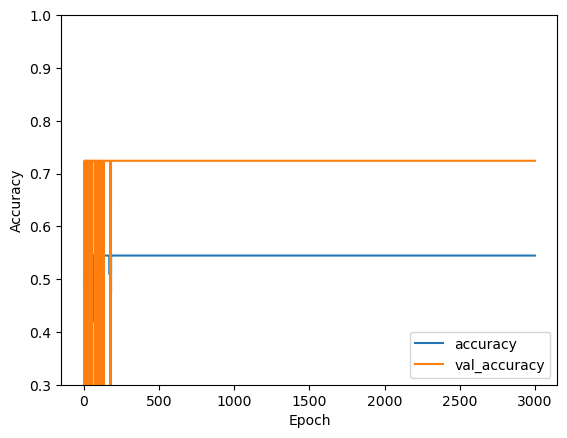

In [13]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

In [14]:
# Make test dataset

# Select 5 control and 5 schizophrenia IDs for the test set
control_test_ids = ['A00035469', 'A00029226', 'A00022915', 'A00022773', 'A00024663']  
schizophrenia_test_ids = ['A00029486', 'A00000541', 'A00028408', 'A00000909', 'A00031186'] 

# Load and preprocess the images
test_image_data = []
test_labels = []

# Combine all test IDs
test_ids = control_test_ids + schizophrenia_test_ids

# Loop through the matching files and filter based on test IDs
for file_path in matching_files:
    filename = os.path.basename(file_path)
    file_id = filename.split('_')[0]

    # Process only if the ID is in the test set
    if file_id in test_ids:
        t1_img = nib.load(file_path)
        t1_data = t1_img.get_fdata()

        # Ensure sufficient time dimension
        if t1_data.shape[3] < 90:
            continue

        # Collapse one of the axes by summing
        t1_data_collapsed = np.sum(t1_data, axis=1)

        # Resize, normalize, and add dimension as done in the training data preparation
        processed_image = resize_image(t1_data_collapsed, (84, 84, 72))
        processed_image_normalized = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image)) * 2 - 1
        processed_image_final = np.expand_dims(processed_image_normalized, axis=-1)

        test_image_data.append(processed_image_final)
        label = 1 if file_id in schizophrenia_test_ids else 0
        test_labels.append(label)

# Convert to numpy arrays
test_images_array = np.array(test_image_data)
test_labels_array = np.array(test_labels)

# Create a dummy array for the label input for the test dataset
dummy_label_input_test = np.zeros((test_images_array.shape[0], 1))

# Create the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_array, dummy_label_input_test, test_labels_array)).batch(batch_size)


In [16]:
# Initialize metrics
test_loss = 0
test_accuracy = 0
num_batches = 0

# Manually iterate over the test dataset
for batch in test_dataset:
    images, dummy_labels, labels = batch

    # Ensure that we're sending two separate inputs (images and dummy labels)
    predictions = classification_model.predict([images, dummy_labels])

    # Calculate loss for the batch
    loss = tf.keras.losses.binary_crossentropy(labels, predictions)
    test_loss += tf.reduce_mean(loss).numpy()

    # Round predictions and cast to integer to match the label's type
    predicted_labels = tf.cast(tf.round(predictions), dtype=labels.dtype)

    # Calculate accuracy for the batch
    accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predicted_labels), dtype=tf.float32))
    test_accuracy += accuracy.numpy()

    num_batches += 1

# Calculate average loss and accuracy
test_loss /= num_batches
test_accuracy /= num_batches

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1/1 [==============================] - 0s 28ms/step
Test Loss: 0.684270441532135, Test Accuracy: 0.5714285969734192
